In [1]:
import os
os.chdir('../ssl_neuron/')

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import json
import gc
import pickle
import copy
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import networkx as nx
import scipy.signal as signal
from allensdk.core.cell_types_cache import CellTypesCache

from allensdk.api.queries.glif_api import GlifApi
import allensdk.core.json_utilities as json_utilities
from allensdk.model.glif.glif_neuron import GlifNeuron

from allensdk.ephys.ephys_extractor import EphysSweepFeatureExtractor

from ssl_neuron.datasets import AllenDataset

import time
import uuid

/home/fpei2/miniconda3/envs/bmed7610/lib/python3.8/site-packages/tqdm-4.64.1-py3.8.egg/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [27]:
ctc = CellTypesCache(manifest_file='./ssl_neuron/data/cell_types/manifest.json')

cells = ctc.get_cells()
cell_df = pd.DataFrame(cells)

ephys_features = ctc.get_ephys_features()
ef_df = pd.DataFrame(ephys_features)

morphology_features = ctc.get_morphology_features()
morph_df = pd.DataFrame(morphology_features)

,reporter_status,cell_soma_location,species,name,structure_layer_name,structure_area_id,structure_area_abbrev,transgenic_line,dendrite_type,apical,reconstruction_type,disease_state,donor_id,structure_hemisphere,normalized_depth
id,,,,,,,,,,,,,,,
313862022,positive,"[9489.24257509068, 1423.65239028148, 2785.4430...",Mus musculus,Scnn1a-Tg2-Cre;Ai14-167081.03.02.01,4,385,VISp,Scnn1a-Tg2-Cre,spiny,intact,dendrite-only,,313401508,right,0.461634
313862167,positive,"[9279.53948496313, 1831.03502009105, 2151.2443...",Mus musculus,Sst-IRES-Cre;Ai14-167638.05.02.01,4,409,VISl,Sst-IRES-Cre,aspiny,NA,full,,313401544,right,0.340213
313862373,positive,"[9465.94223174317, 2210.36351644808, 2482.0829...",Mus musculus,Pvalb-IRES-Cre;Ai14-165171.03.01.01,6a,409,VISl,Pvalb-IRES-Cre,aspiny,NA,full,,312883105,left,0.841597
314642645,positive,"[9396.04120170065, 1466.39421665714, 2676.1811...",Mus musculus,Rorb-IRES2-Cre-D;Ai14-168052.03.02.01,4,385,VISp,Rorb-IRES2-Cre,spiny,intact,dendrite-only,,313403614,right,0.352524
314804042,positive,"[8766.93193131801, 1245.0648598059, 8245.14719...",Mus musculus,Rorb-IRES2-Cre-D;Ai14-168053.05.01.01,5,385,VISp,Rorb-IRES2-Cre,spiny,intact,dendrite-only,,313403626,left,0.494978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605660220,positive,"[8435.88461497855, 1565.32145439185, 8695.5190...",Mus musculus,Penk-IRES2-Cre-neo;Ai14-336495.04.01.01,6a,385,VISp,Penk-IRES2-Cre-neo,spiny,intact,dendrite-only,,604669312,left,0.780030
607124114,positive,"[8511.0, 1240.02954240346, 8318.40352036628]",Mus musculus,Tlx3-Cre_PL56;Ai14-338859.04.01.01,5,385,VISp,Tlx3-Cre_PL56,spiny,intact,dendrite-only,,606162417,left,0.652086
609435731,positive,"[8253.0, 593.839010501723, 3532.39427084889]",Mus musculus,Vipr2-IRES2-Cre;Slc32a1-T2A-FlpO;Ai65-343382.0...,2/3,385,VISp,Slc32a1-T2A-FlpO|Vipr2-IRES2-Cre,aspiny,NA,full,,607117989,right,0.161134


In [4]:
model_scores = []
for score_file in sorted(os.listdir('../analysis/glif_models/scores/')):
    cell_id = int(score_file.replace('.json', '').strip())
    with open(os.path.join('../analysis/glif_models/scores/', score_file), 'r') as f:
        cell_scores = json.load(f)
    cell_scores['cell_id'] = cell_id
    model_scores.append(cell_scores)
model_scores = pd.DataFrame(model_scores)

In [5]:
model_scores

,cell_id,noise_1_ll_var,noise_1_ln_var,noise_1_cl_var,noise_1_cn_var,noise_1_ml_var,noise_1_mn_var,noise_1_lcl_var,noise_1_lcn_var,noise_1_lml_var,noise_1_lmn_var,noise_1_cml_var,noise_1_cmn_var,noise_1_lcml_var,noise_1_lcmn_var,noise_1_base_var
0,313862022,0.586185,0.685673,0.591501,0.712325,0.547377,0.688189,0.601005,0.666817,0.557150,0.725836,0.563686,0.739120,0.538015,0.730244,NaN
1,313862167,0.259006,0.281190,0.446394,0.884670,0.378315,0.542249,0.295504,0.426578,0.928880,0.349556,0.376814,0.538186,0.302889,0.475076,0.917555
2,313862373,0.768285,0.785640,0.558272,0.761468,0.648939,0.576965,0.537144,0.749615,0.653775,0.591037,0.437869,0.544452,0.488939,0.581405,NaN
3,314642645,0.268493,0.165039,0.150289,0.000000,0.366368,0.489974,0.305877,0.322429,0.296704,0.628517,0.299218,0.510085,0.402816,0.657567,0.692379
4,314804042,0.440394,0.442533,0.362114,0.304187,0.414376,0.414837,0.457814,0.422590,0.433268,0.291098,0.384606,0.387695,0.398498,0.336926,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372,605660220,0.000000,0.000000,0.000000,0.000000,0.212164,0.044088,0.000000,0.000000,0.049139,0.179294,0.000000,0.000000,0.037500,0.042147,0.475709
373,607124114,0.000000,0.000000,0.050094,0.111523,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
374,609435731,0.305687,0.911530,0.446841,0.809209,0.614249,0.645089,0.310582,0.900634,0.438741,0.763178,0.659486,0.681351,0.448957,0.762314,0.950867
375,614767057,0.393138,0.725851,0.875484,0.772950,0.352360,0.345122,0.866666,0.310255,0.335458,0.585569,0.867443,0.463769,0.883146,0.422273,0.927617


In [6]:
pd.isna(model_scores.noise_1_base_var).sum()

133

In [14]:
model_scores.mean()

cell_id             5.111632e+08
noise_1_ll_var      3.999337e-01
noise_1_ln_var      4.172216e-01
noise_1_cl_var      3.939253e-01
noise_1_cn_var      4.430359e-01
noise_1_ml_var      3.852354e-01
noise_1_mn_var      4.353640e-01
noise_1_lcl_var     3.881871e-01
noise_1_lcn_var     4.085027e-01
noise_1_lml_var     4.097198e-01
noise_1_lmn_var     4.517462e-01
noise_1_cml_var     4.028773e-01
noise_1_cmn_var     4.386504e-01
noise_1_lcml_var    4.028595e-01
noise_1_lcmn_var    4.527751e-01
noise_1_base_var    6.872188e-01
dtype: float64

(0.0, 1.0)

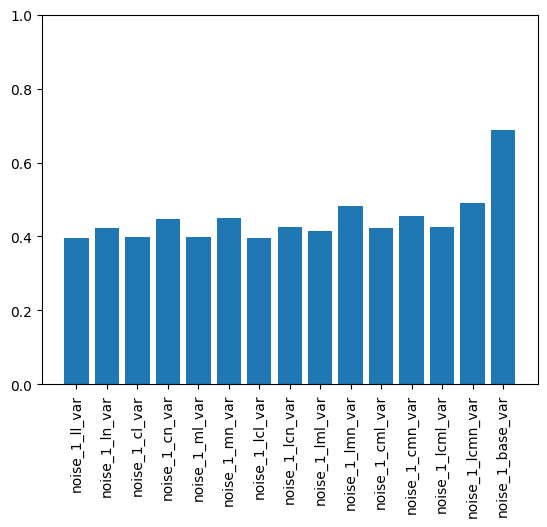

In [25]:
mean_scores = model_scores[~pd.isna(model_scores.noise_1_base_var)].iloc[:, 1:].mean()
plt.bar(mean_scores.index, mean_scores)
plt.xticks(rotation=90)
plt.ylim(0,1)

In [7]:
has_model_mask = ~pd.isna(model_scores.noise_1_base_var)
base_model_scores = model_scores[has_model_mask].noise_1_base_var

diff_mean = {}
diff_std = {}

for col in model_scores.columns:
    if col in ['cell_id', 'noise_1_base_var']:
        continue
    scores = model_scores[has_model_mask][col]
    diff = scores - base_model_scores
    diff_mean[col] = np.mean(diff)
    diff_std[col] = np.std(diff)

(-0.4, 0.0)

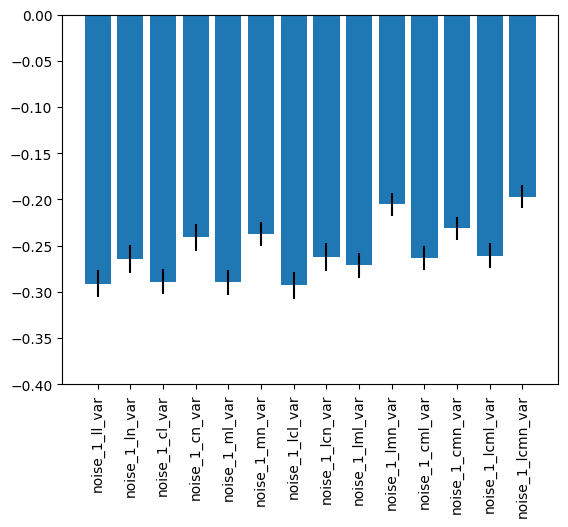

In [26]:
plt.bar(list(diff_mean.keys()), list(diff_mean.values()), yerr=np.array(list(diff_std.values())) / np.sqrt(has_model_mask.sum()))
plt.xticks(rotation=90)
plt.ylim(-0.4, 0)

In [33]:
cell_df = cell_df.set_index('id').loc[model_scores.cell_id]
morph_df = morph_df.set_index('specimen_id').loc[model_scores.cell_id]
ef_df = ef_df.set_index('specimen_id').loc[model_scores.cell_id]

In [42]:
cell_df.columns

Index(['reporter_status', 'cell_soma_location', 'species', 'name',
       'structure_layer_name', 'structure_area_id', 'structure_area_abbrev',
       'transgenic_line', 'dendrite_type', 'apical', 'reconstruction_type',
       'disease_state', 'donor_id', 'structure_hemisphere',
       'normalized_depth'],
      dtype='object')

In [50]:
from sklearn.preprocessing import LabelEncoder
discretized = LabelEncoder().fit_transform(cell_df[has_model_mask.to_numpy()].transgenic_line)

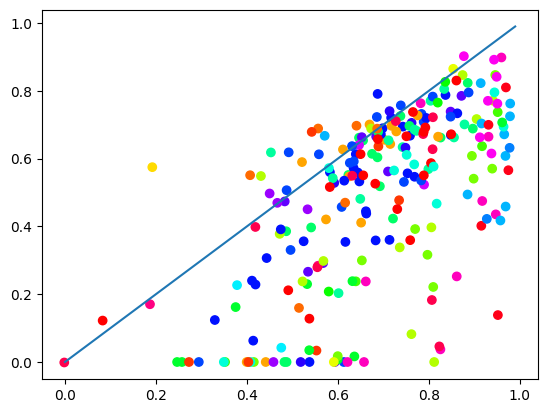

In [54]:
col = 'noise_1_lcmn_var'
pred_scores = model_scores[has_model_mask][col]
plt.scatter(base_model_scores, pred_scores, c=discretized, cmap=plt.cm.hsv)
plt.plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01))